In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models



from sklearn.metrics import classification_report,confusion_matrix
from torchvision import datasets, transforms as T
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from PIL import Image
from pathlib import Path
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fathurrahmanalfarizy/sampah-daur-ulang")

print("Path to dataset files:", path)

100%|██████████| 98.5M/98.5M [00:04<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fathurrahmanalfarizy/sampah-daur-ulang/versions/5


In [3]:
main_dir = os.path.join(path, 'DATASETS')

if os.path.exists(main_dir):
    print(f"Dataset ditemukan di: {main_dir}")
else:
    print("Dataset tidak ditemukan di path yang diberikan.")


dataset_classes = os.listdir(main_dir)


print("\nKelas-kelas yang ada dalam dataset:")
for idx, class_name in enumerate(dataset_classes, 1):
    print(f"{idx}. {class_name}")


for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
        print(f"Jumlah gambar di kelas '{class_name}': {num_images}")


Dataset ditemukan di: /root/.cache/kagglehub/datasets/fathurrahmanalfarizy/sampah-daur-ulang/versions/5/DATASETS

Kelas-kelas yang ada dalam dataset:
1. Logam
2. Residu
3. Kardus
4. Plastik
5. Kertas
6. Kaca
Jumlah gambar di kelas 'Logam': 1210
Jumlah gambar di kelas 'Residu': 1002
Jumlah gambar di kelas 'Kardus': 624
Jumlah gambar di kelas 'Plastik': 1256
Jumlah gambar di kelas 'Kertas': 1807
Jumlah gambar di kelas 'Kaca': 1110


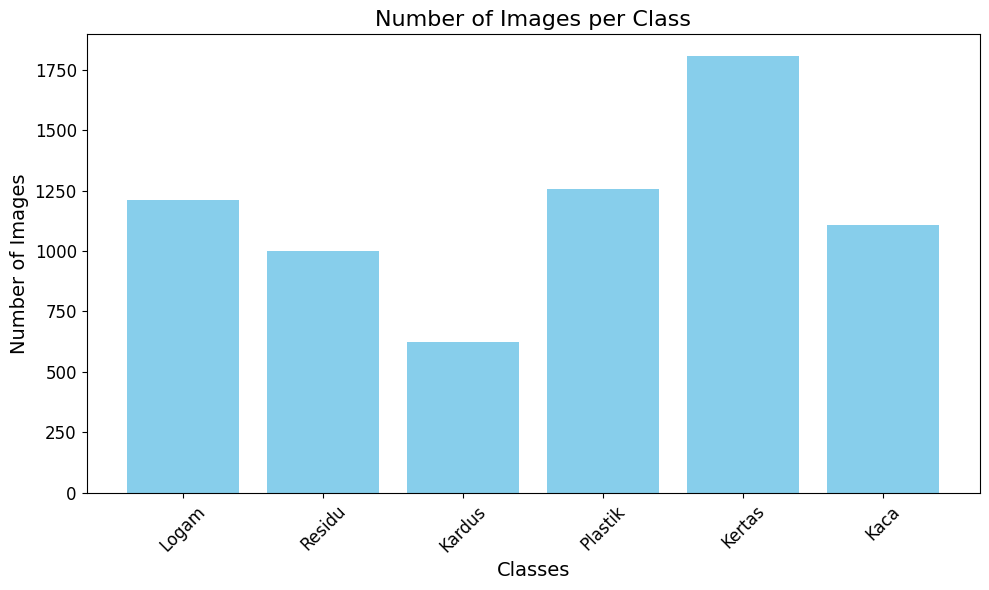

In [4]:
# Mengecek apakah direktori dataset ada
if not os.path.exists(main_dir):
    raise FileNotFoundError(f"Dataset tidak ditemukan di: {main_dir}")

# Menggunakan os untuk menghitung jumlah gambar di masing-masing kelas
class_counts = {}
dataset_classes = os.listdir(main_dir)

for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
        class_counts[class_name] = num_images

# Menampilkan hasil dalam diagram batang
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Number of Images per Class', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [5]:
import os
import shutil
import random

# Target jumlah gambar per kelas
TARGET_NUM_IMAGES = 1000

for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)

    if os.path.isdir(class_dir):
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
        num_images = len(image_files)

        if num_images < TARGET_NUM_IMAGES:
            while num_images < TARGET_NUM_IMAGES:
                # Pilih gambar secara acak untuk diduplikasi
                image_to_duplicate = random.choice(image_files)
                src_path = os.path.join(class_dir, image_to_duplicate)

                # Nama file baru untuk gambar duplikat
                base_name, ext = os.path.splitext(image_to_duplicate)
                new_image_name = f"{base_name}_dup{num_images}{ext}"
                dst_path = os.path.join(class_dir, new_image_name)

                shutil.copy(src_path, dst_path)
                image_files.append(new_image_name)
                num_images += 1

        elif num_images > TARGET_NUM_IMAGES:
            images_to_remove = random.sample(image_files, num_images - TARGET_NUM_IMAGES)
            for image_to_remove in images_to_remove:
                os.remove(os.path.join(class_dir, image_to_remove))
                num_images -= 1

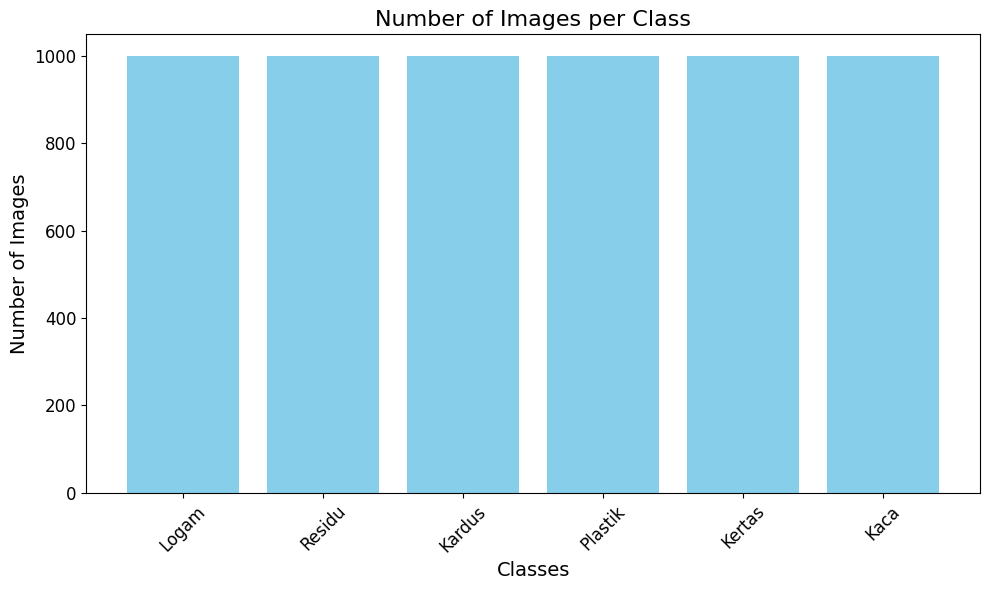

In [6]:
# Mengecek apakah direktori dataset ada
if not os.path.exists(main_dir):
    raise FileNotFoundError(f"Dataset tidak ditemukan di: {main_dir}")

# Menggunakan os untuk menghitung jumlah gambar di masing-masing kelas
class_counts = {}
dataset_classes = os.listdir(main_dir)

for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
        class_counts[class_name] = num_images

# Menampilkan hasil dalam diagram batang
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Number of Images per Class', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


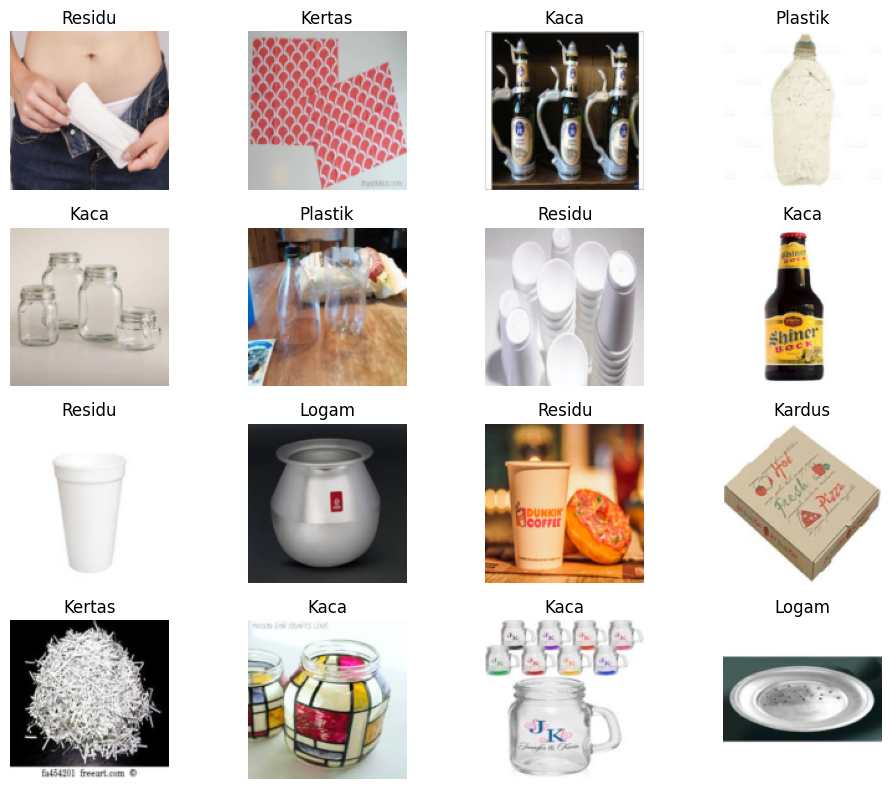

In [7]:

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize gambar
    transforms.ToTensor()          # Konversi ke tensor
])

# Memuat dataset menggunakan ImageFolder
dataset = ImageFolder(root=main_dir, transform=transform)

# Membuat DataLoader untuk batch
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Menampilkan batch pertama
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Plot batch gambar
def show_batch(images, labels, class_names):
    fig, axes = plt.subplots(4, 4, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))  # Permute tensor ke format HWC
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Mendapatkan kelas dari dataset
class_names = dataset.classes

# Menampilkan gambar batch
show_batch(images, labels, class_names)


In [8]:
# Membuat folder train dan test
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Memisahkan dataset menjadi train dan test
split_ratio = 0.8  # 80% train, 20% test

for class_name in dataset_classes:
    class_dir = os.path.join(main_dir, class_name)
    if os.path.isdir(class_dir):
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
        random.shuffle(image_files)

        train_count = int(len(image_files) * split_ratio)
        train_images = image_files[:train_count]
        test_images = image_files[train_count:]

        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for image in train_images:
            shutil.move(os.path.join(class_dir, image), os.path.join(train_class_dir, image))

        for image in test_images:
            shutil.move(os.path.join(class_dir, image), os.path.join(test_class_dir, image))



In [9]:
def count_samples_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            num_images = len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_samples_in_directory(train_dir)
test_counts = count_samples_in_directory(test_dir)

print("\nJumlah sampel di train_dir:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nJumlah sampel di test_dir:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")



Jumlah sampel di train_dir:
Logam: 800 images
Residu: 800 images
Kardus: 800 images
Plastik: 800 images
Kertas: 800 images
Kaca: 800 images

Jumlah sampel di test_dir:
Logam: 200 images
Residu: 200 images
Kardus: 200 images
Plastik: 200 images
Kertas: 200 images
Kaca: 200 images


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=20,
    brightness_range=[0.2, 1.2],
    horizontal_flip=True,
    shear_range=0.2,
    channel_shift_range=50
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi untuk validasi

img_h = 224
img_w = 224

# Memuat data dari folder train, val, dan test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_h, img_w),  # Resolusi input ke CNN
    batch_size=32,           # Ukuran batch
    class_mode='categorical' # Klasifikasi multi-kelas
)

validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_h, img_w),
    batch_size=32,
    class_mode='categorical'
)

Found 4800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


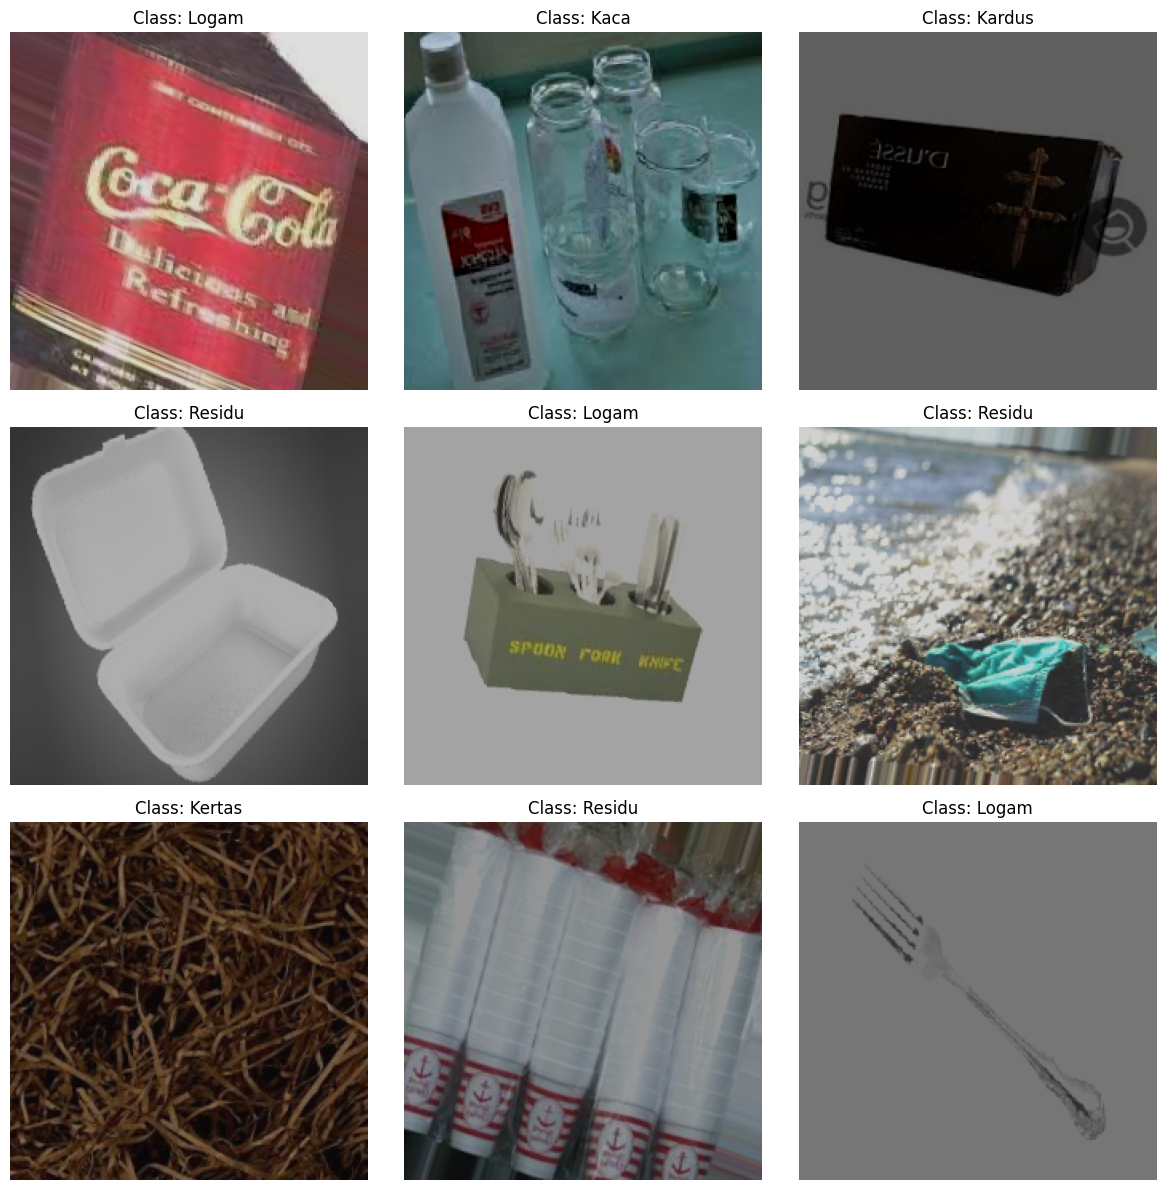

In [14]:
# Mendapatkan batch pertama dari train_generator
images, labels = next(train_generator)

# Konversi one-hot encoding ke label kelas
class_indices = {v: k for k, v in train_generator.class_indices.items()}
decoded_labels = [class_indices[label.argmax()] for label in labels]

# Menampilkan beberapa gambar dengan label
plt.figure(figsize=(12, 12))
for i in range(9):  # Menampilkan 9 gambar pertama
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {decoded_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


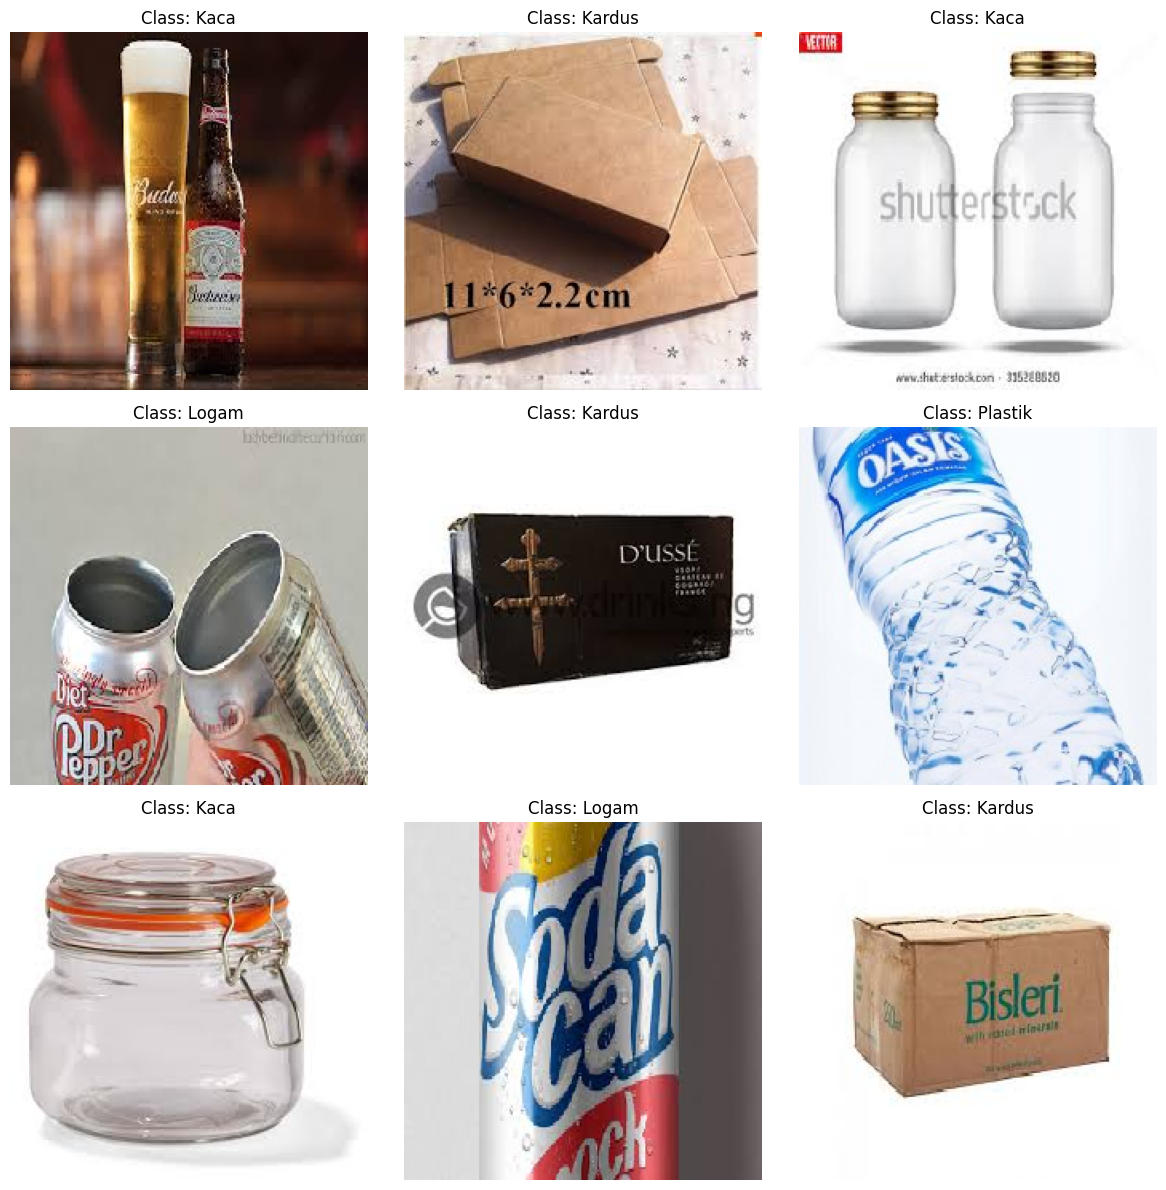

In [15]:
# Mendapatkan batch pertama dari train_generator
images, labels = next(validation_generator)

# Konversi one-hot encoding ke label kelas
class_indices = {v: k for k, v in train_generator.class_indices.items()}
decoded_labels = [class_indices[label.argmax()] for label in labels]

# Menampilkan beberapa gambar dengan label
plt.figure(figsize=(12, 12))
for i in range(9):  # Menampilkan 9 gambar pertama
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {decoded_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# Add custom layers
inputs = layers.Input(shape=(img_h, img_w, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x) # over vit dengan beda 20% jika tanpa Dropout
outputs = layers.Dense(6, activation='softmax')(x)

model = models.Model(inputs, outputs)



model.summary()


# pre_trained_model = MobileNetV2(weights="imagenet",
#                                 include_top=False,
#                                 input_tensor=Input(shape=(224, 224, 3)))

# for layer in pre_trained_model.layers:
#     layer.trainable = False

# model = Sequential()
# model.add(pre_trained_model)
# model.add(Conv2D(128, (3, 3), activation="relu"))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten(name="flatten"))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation="relu"))
# model.add(Dense(14, activation='softmax'))

# model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,756,742 (14.33 MB)

 Trainable params: 3,734,854 (14.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [19]:
# === Bagian 3: Compile Model ===

model.compile(optimizer=Adam(learning_rate=0.001), # lr reducer
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Bagian 4: Train Model ===

early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True) #monitor - akurasi atau auc kalau pakai auc

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)



Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 97s 483ms/step - accuracy: 0.7221 - loss: 0.8315 - val_accuracy: 0.6058 - val_loss: 1.5783
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 130s 472ms/step - accuracy: 0.7849 - loss: 0.6692 - val_accuracy: 0.7267 - val_loss: 0.8690
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 468ms/step - accuracy: 0.8246 - loss: 0.5639 - val_accuracy: 0.7825 - val_loss: 0.7830
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 467ms/step - accuracy: 0.8210 - loss: 0.5501 - val_accuracy: 0.7292 - val_loss: 0.9113
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 466ms/step - accuracy: 0.8480 - loss: 0.4541 - val_accuracy: 0.7283 - val_loss: 1.1139
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 487ms/step - accuracy: 0.8624 - loss: 0.4377 - val_accuracy: 0.8258 - val_loss: 0.5363
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 464ms/step - accuracy: 0.8630 - loss: 0.4288 - val_accuracy: 0.8000 - val_loss: 0.6614
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 485ms/step - accuracy: 0.8749 - loss: 

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8716 - loss: 0.4751

Test Accuracy: 0.88


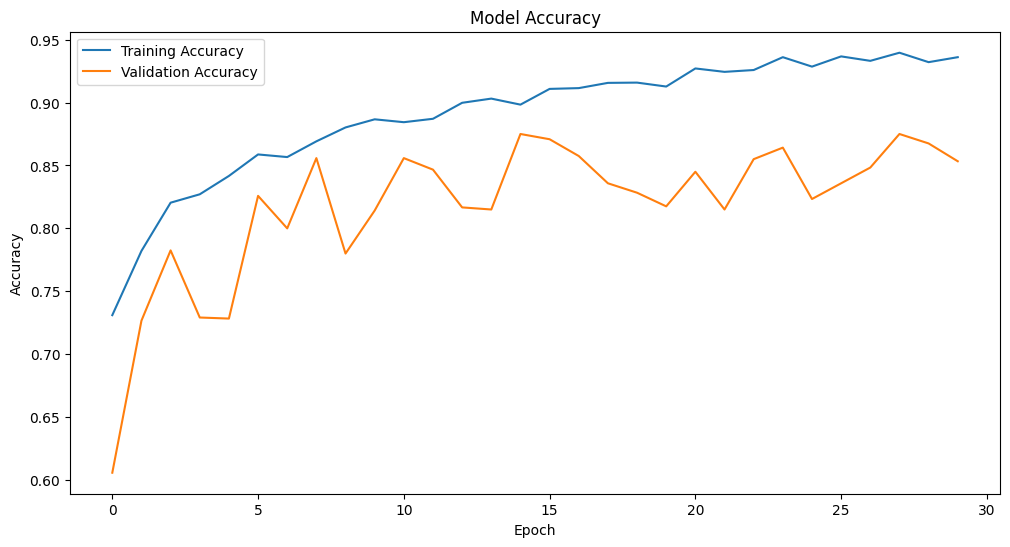

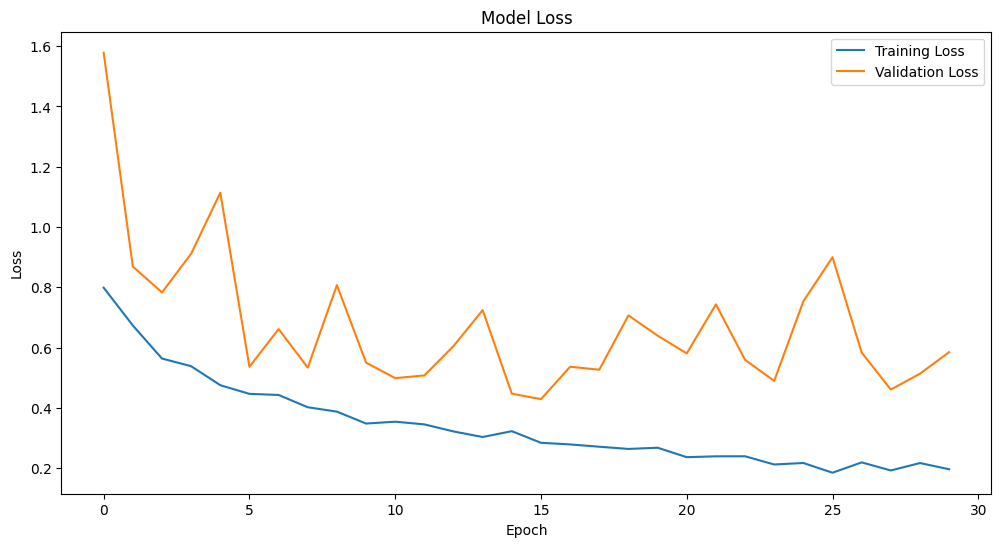

In [20]:
# === Bagian 5: Evaluate Model ===

loss, accuracy = model.evaluate(validation_generator)
print(f"\nTest Accuracy: {accuracy:.2f}")

# === Bagian 6: Visualisasi Hasil Training ===

import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step


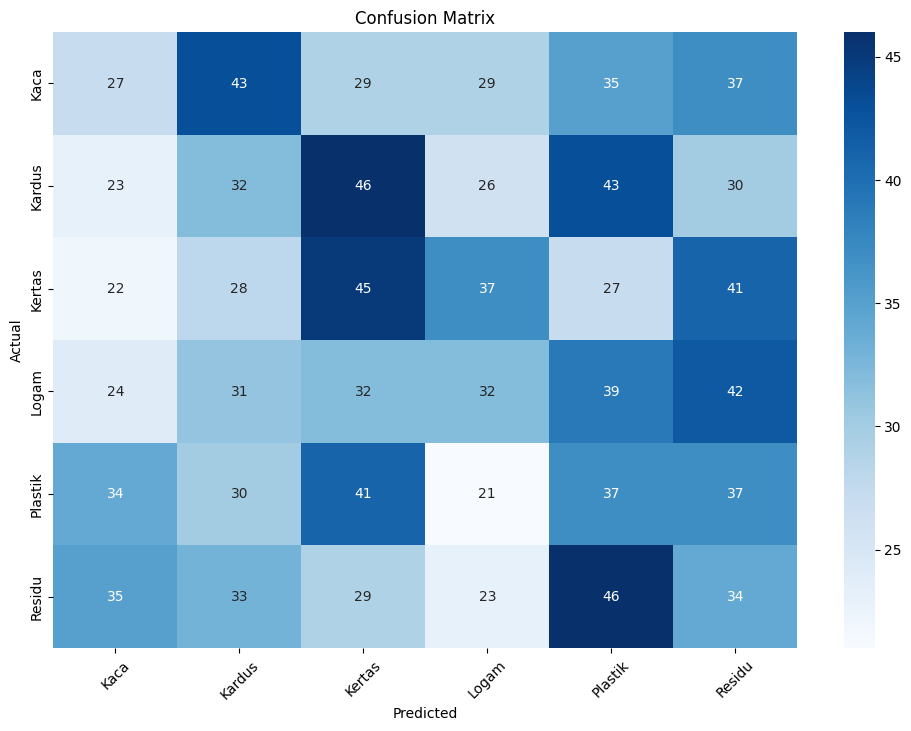

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan class names diambil dari generator
class_names = list(validation_generator.class_indices.keys())

# Reset validation generator
validation_generator.reset()

# Generate predictions
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot confusion matrix with rotated x-axis labels
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues')
plt.xticks(rotation=45)  # Rotate x-axis tick labels by 45 degrees
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
y_val = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_val,y_pred))

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
              precision    recall  f1-score   support

           0       0.18      0.12      0.15       200
           1       0.15      0.15      0.15       200
           2       0.18      0.21      0.20       200
           3       0.16      0.18      0.17       200
           4       0.16      0.17      0.17       200
           5       0.19      0.15      0.17       200

    accuracy                           0.17      1200
   macro avg       0.17      0.17      0.17      1200
weighted avg       0.17      0.17      0.17      1200



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


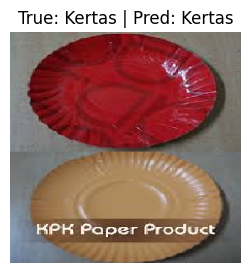

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


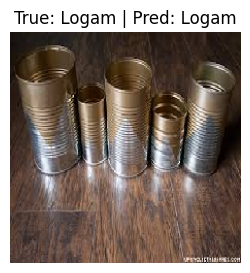

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


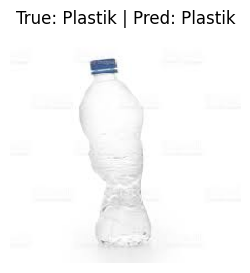

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


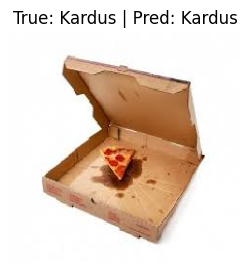

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


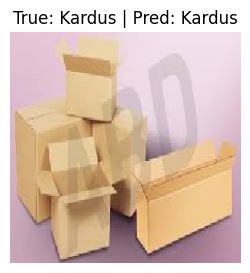

In [22]:


# Function to display image and its prediction
def display_random_predictions(generator, model, num_images=5):
    # Convert class indices to a list for easy indexing
    class_labels = list(generator.class_indices.keys())

    # Get a batch of images and labels
    images, labels = next(iter(generator))

    # Loop through the number of images you want to display
    for i in range(num_images):
        image = images[i]
        label = labels[i]

        # Get model predictions for the image
        prediction = model.predict(np.expand_dims(image, axis=0))  # Model expects batch dimension
        predicted_class = np.argmax(prediction, axis=-1)[0]  # Get the class index with the highest probability (scalar value)
        true_class = np.argmax(label, axis=-1)  # Get the true class index

        # Display the image with its true label and predicted label
        plt.figure(figsize=(3,3))
        plt.imshow(image)
        plt.title(f"True: {class_labels[true_class]} | Pred: {class_labels[predicted_class]}")
        plt.axis('off')
        plt.show()

# Call the function to display random predictions
display_random_predictions(validation_generator, model, num_images=5)
